<a href="https://colab.research.google.com/github/tsaialice9/HW1_VAE_MNIST/blob/main/HW9_LLM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Train risk counts:
 risk
0    7238
2    4666
1    4096
Name: count, dtype: int64


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3083276792.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,F1,Auroc,Pr Auc
100,0.712600,0.599169,0.721938,0.897463,0.849926
200,0.485700,0.479823,0.771067,0.936906,0.901575
300,0.462200,0.421541,0.807258,0.951690,0.923924
400,0.442500,0.371484,0.834770,0.962642,0.940167
500,0.401300,0.327394,0.858574,0.968775,0.951664
600,0.313300,0.311312,0.859394,0.972884,0.956133
700,0.307500,0.288465,0.876226,0.977052,0.962392
800,0.334900,0.268262,0.885545,0.979086,0.966689
900,0.317700,0.264776,0.889805,0.979680,0.967405
1000,0.315700,0.257290,0.889312,0.980292,0.969050


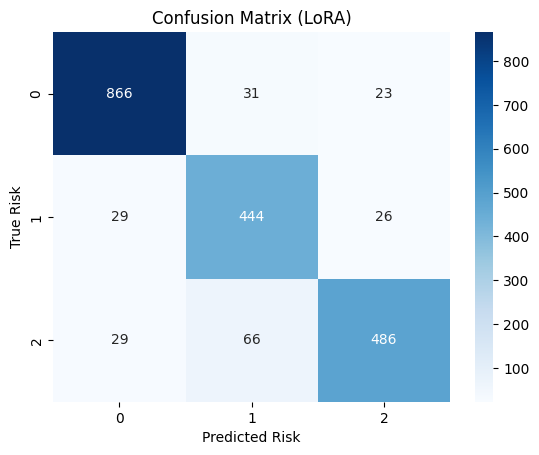

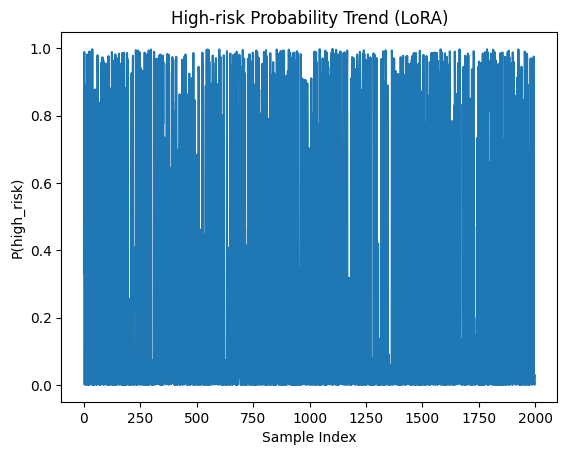

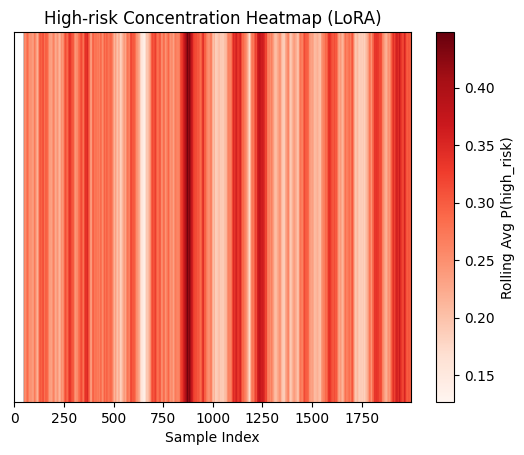

Device set to use cuda:0
100%|██████████| 2000/2000 [00:19<00:00, 101.45it/s]


三種方法比較表格：
      Method        F1     AUROC    PR-AUC
0       LoRA  0.888025  0.977829  0.964026
1  Zero-shot  0.150071  0.500000  0.408750
2   Few-shot  0.150071  0.500000  0.408750


In [ ]:
# ======================================================
# HW9 —LLM 微調：情緒分類與憂鬱症風險監測
# ======================================================

# 0️ 安裝套件
!pip install -q datasets transformers scikit-learn matplotlib seaborn accelerate peft bitsandbytes tqdm

# 1️ 基本匯入
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from peft import LoraConfig, get_peft_model
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os


os.environ["WANDB_DISABLED"] = "true"

device = "cuda" if torch.cuda.is_available() else "cpu"

# 2️ 載入 Emotion dataset
dataset = load_dataset('dair-ai/emotion')
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

label_names = dataset['train'].features['label'].names
print("Emotion labels:", label_names)

# Emotion → Risk mapping
emotion_to_risk = {'joy':0,'love':0,'surprise':0,'anger':1,'fear':1,'sadness':2}
for df in (train_df, val_df, test_df):
    df['emotion'] = df['label'].apply(lambda x: label_names[x])
    df['risk'] = df['emotion'].map(emotion_to_risk)

print("Train risk counts:\n", train_df['risk'].value_counts())

# 3️ Tokenization
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=64)

# 將 DataFrame 轉成 HF Dataset
hf_train = Dataset.from_pandas(train_df[['text','risk']]).map(tokenize, batched=True)
hf_val   = Dataset.from_pandas(val_df[['text','risk']]).map(tokenize, batched=True)
hf_test  = Dataset.from_pandas(test_df[['text','risk']]).map(tokenize, batched=True)

#  Trainer 預設期望 label 欄位名稱為 'labels'
hf_train = hf_train.rename_column("risk", "labels")
hf_val   = hf_val.rename_column("risk", "labels")
hf_test  = hf_test.rename_column("risk", "labels")

hf_train.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
hf_val.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
hf_test.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

# 4️ LoRA 微調
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_lin","v_lin"],  # DistilBERT 對應名稱
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)
model = get_peft_model(base_model, lora_config)
model.to(device)

# 5️ TrainingArguments
training_args = TrainingArguments(
    output_dir="./lora_emotion",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    learning_rate=2e-4,
    logging_steps=50,
    eval_steps=100,
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    eval_strategy="steps",
    save_strategy="steps",
    report_to=[]
)

# 評估函數
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, preds, average='macro')

    try:
        probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
        labels_onehot = np.eye(3)[labels]
        auroc = roc_auc_score(labels_onehot, probs, multi_class='ovr')
        precision, recall, _ = precision_recall_curve(labels_onehot.ravel(), probs.ravel())
        pr_auc = auc(recall, precision)
    except:
        auroc = 0.0
        pr_auc = 0.0

    return {"f1": f1, "auroc": auroc, "pr_auc": pr_auc}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 訓練
trainer.train()

# 6️ 測試集評估 (LoRA)
preds_output = trainer.predict(hf_test)
preds_lora = np.argmax(preds_output.predictions, axis=-1)
labels = np.array(hf_test['labels'])

# Confusion Matrix
cm = confusion_matrix(labels, preds_lora)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Risk")
plt.ylabel("True Risk")
plt.title("Confusion Matrix (LoRA)")
plt.show()

# 高風險走勢圖
probs_lora = torch.softmax(torch.tensor(preds_output.predictions), dim=-1).numpy()
high_risk_prob = probs_lora[:,2]
plt.plot(high_risk_prob)
plt.title("High-risk Probability Trend (LoRA)")
plt.xlabel("Sample Index")
plt.ylabel("P(high_risk)")
plt.show()

# 高風險濃度熱圖
window = 50
rolling_avg = pd.Series(high_risk_prob).rolling(window).mean()
plt.imshow(np.expand_dims(rolling_avg.values, axis=0), aspect='auto', cmap='Reds')
plt.title("High-risk Concentration Heatmap (LoRA)")
plt.yticks([])
plt.xlabel("Sample Index")
plt.colorbar(label='Rolling Avg P(high_risk)')
plt.show()

# 7️ Zero-shot 推論 + 評估
zero_shot_model = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# 對 test set 推論
preds_zero = []
for text in tqdm(test_df['text'].tolist()):
    pred = zero_shot_model(text)[0]['label']
    if 'low' in pred.lower():
        preds_zero.append(0)
    elif 'mid' in pred.lower():
        preds_zero.append(1)
    else:
        preds_zero.append(2)

# 評估 Zero-shot
labels_onehot = np.eye(3)[labels]
f1_zero = f1_score(labels, preds_zero, average='macro')
probs_zero = np.zeros_like(labels_onehot, dtype=float)
for i, val in enumerate(preds_zero):
    probs_zero[i,val] = 1.0
auroc_zero = roc_auc_score(labels_onehot, probs_zero, multi_class='ovr')
precision, recall, _ = precision_recall_curve(labels_onehot.ravel(), probs_zero.ravel())
pr_auc_zero = auc(recall, precision)

# 8️ Few-shot 推論 + 評估
few_shot_prompt = """以下為文本情緒分類示例：
Example 1: I am happy today. → low risk
Example 2: I feel anxious and scared. → mid risk
Example 3: I am very sad. → high risk
Example 4: I am feeling excited. → low risk
Example 5: I am angry about the situation. → mid risk

請判斷以下文本的憂鬱症風險：
"""
few_shot_preds = []
for text in tqdm(test_df['text'].tolist()):
    input_text = few_shot_prompt + text
    pred = zero_shot_model(input_text)[0]['label']
    if 'low' in pred.lower():
        few_shot_preds.append(0)
    elif 'mid' in pred.lower():
        few_shot_preds.append(1)
    else:
        few_shot_preds.append(2)

# 評估 Few-shot
few_probs = np.zeros_like(labels_onehot, dtype=float)
for i, val in enumerate(few_shot_preds):
    few_probs[i, val] = 1.0
f1_few = f1_score(labels, few_shot_preds, average='macro')
auroc_few = roc_auc_score(labels_onehot, few_probs, multi_class='ovr')
precision, recall, _ = precision_recall_curve(labels_onehot.ravel(), few_probs.ravel())
pr_auc_few = auc(recall, precision)

# 9️ 三種方法比較表格
results_df = pd.DataFrame({
    "Method": ["LoRA", "Zero-shot", "Few-shot"],
    "F1": [
        f1_score(labels, preds_lora, average='macro'),
        f1_zero,
        f1_few
    ],
    "AUROC": [
        roc_auc_score(labels_onehot, probs_lora, multi_class='ovr'),
        auroc_zero,
        auroc_few
    ],
    "PR-AUC": [
        auc(*precision_recall_curve(labels_onehot.ravel(), probs_lora.ravel())[:2][::-1]),
        pr_auc_zero,
        pr_auc_few
    ]
})
print("三種方法比較表格：")
print(results_df)
